In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual

# from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.zoning_models.tracts_model import TractsModel

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
# smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:

census_tracts_data_path = os.path.join(root, "data/minneapolis/processed/census_tracts_dataset.pt")


ct_dataset_read = torch.load(census_tracts_data_path)

ct_loader = DataLoader(
    ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True
)

data = next(iter(ct_loader))

print(data["continuous"].keys())
print(data['categorical'].keys())   

kwargs = {
    "categorical": [
        "year_original",
        "year",
        "census_tract"
    ],
    "continuous": {
      'housing_units',
      'total_value',
      'median_value',
      'mean_limit_original',
      'median_distance',
      'income',
      'segregation_original',
      'white_original',
    },
    'outcome': 'housing_units'
}

subset = select_from_data(data, kwargs)
print(subset["continuous"].keys())
print(subset['continuous']['housing_units'].shape)
print(subset['categorical']['census_tract'].shape)

tracts_model = TractsModel(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)


subset_for_preds = copy.deepcopy(subset)
subset_for_preds['continuous']['housing_units'] = None  

dict_keys(['housing_units', 'housing_units_original', 'income', 'income_original', 'mean_distance', 'mean_distance_original', 'mean_limit', 'mean_limit_original', 'median_distance', 'median_distance_original', 'median_value', 'median_value_original', 'segregation', 'segregation_original', 'total_value', 'total_value_original', 'white', 'white_original'])
dict_keys(['year_original', 'year', 'census_tract'])
dict_keys(['housing_units', 'income', 'mean_limit_original', 'median_distance', 'median_value', 'segregation_original', 'total_value', 'white_original'])
torch.Size([816])
torch.Size([816])


In [3]:
pyro.clear_param_store()

guide_path = os.path.join(root, "data/minneapolis/guides", "tracts_model_guide.pkl")

param_path = os.path.join(root, "data/minneapolis/guides", "tracts_model_params.pth")

with open(guide_path, "rb") as file:
    guide = dill.load(file)

pyro.get_param_store().load(param_path)

predictive = Predictive(
    model=tracts_model, guide=guide, num_samples=num_samples, parallel=True
)

In [4]:
# RUN ONCE TO GENERATE BACKGROUND DATA USED FOR INTERVENTION CONSTRUCTION

# data  = copy.deepcopy(values[['limit_con', 'downtown_yn', 'year', 'distance_to_transit',
#                              'parcel', 'census_tract']])

# data.to_csv(os.path.join(root, "data/minneapolis/processed/census_tract_intervention_required.csv"))

# census_ids = pd.DataFrame({'census_tract':subset['categorical']['census_tract'].numpy(), 
#                            'year':subset['categorical']['year_original'].numpy()})
# census_ids.to_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

In [5]:
# data = pd.read_csv(os.path.join(root,
#              "data/minneapolis/processed/census_tract_intervention_required.csv"))

# census_ids = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

# display(data.head())
# display(census_ids.head())

In [6]:

def values_intervention(radius_blue, limit_blue, 
                radius_yellow, limit_yellow, reform_year = 2015):
    

    # don't want to load large data multiple times
    
    if not hasattr(values_intervention, "global_census_ids"):   
        values_intervention.global_census_ids = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

        values_intervention.global_data = pd.read_csv(os.path.join(root,
            "data/minneapolis/processed/census_tract_intervention_required.csv"))

        data = values_intervention.global_data
        census_ids = values_intervention.global_census_ids    
        values_intervention.global_data = data[
            (data['census_tract'].isin(census_ids['census_tract'])) & 
            (data['year'].isin(census_ids['year']))]
        
    data = values_intervention.global_data.copy()

    intervention = copy.deepcopy(values_intervention.global_data['limit_con'])
    downtown = data['downtown_yn']
    new_blue = (~downtown) & (data['year'] >= reform_year) & (data["distance_to_transit"] <= radius_blue)
    new_yellow = (
            (~downtown)
            & (data["year"] >= reform_year)
            & (data["distance_to_transit"] > radius_blue)
            & (data["distance_to_transit"] <= radius_yellow)
        )
    new_other = (
        (~downtown) & (data['year'] > reform_year) & (data["distance_to_transit"] > radius_yellow)
    )

    intervention[downtown] = 0.0
    intervention[new_blue] = limit_blue
    intervention[new_yellow] = limit_yellow
    intervention[new_other] = 1.0

    data['intervention'] = intervention 

    return data

#note subsequent runs are much faster
start = time.time()
simple_intervention = values_intervention(300, .5, 700, .7, reform_year = 2015)
end = time.time()
print("Time to run values_intervention 1: ", end - start)
start2 = time.time()
simple_intervention2 = values_intervention(400, .5, 800, .6, reform_year = 2013)
end2 = time.time()

print("Time to run values_intervention 2: ", end2 - start2)


start3 = time.time()
simple_intervention3 = values_intervention(200, .4, 1000, .65, reform_year = 2013)
end3 = time.time()


print("Time to run values_intervention 3: ", end3 - start3)


Time to run values_intervention 1:  0.8408167362213135
Time to run values_intervention 2:  0.058393239974975586
Time to run values_intervention 3:  0.056142568588256836


In [7]:
def tracts_intervention (radius_blue, limit_blue, 
                radius_yellow, limit_yellow, reform_year = 2015):
    
    parcel_interventions = values_intervention(radius_blue, limit_blue,
                        radius_yellow, limit_yellow, reform_year = reform_year)

    aggregate = parcel_interventions[['census_tract', 'year', 'intervention']].groupby(['census_tract', 'year']).mean().reset_index()

    if not hasattr(tracts_intervention, "global_census_ids"):

        tracts_intervention.global_valid_pairs = set(zip(values_intervention.global_census_ids['census_tract'],
                                     values_intervention.global_census_ids['year']))


    subaggregate = aggregate[aggregate[['census_tract', 'year']].apply(tuple, axis=1).isin(tracts_intervention.global_valid_pairs)].copy()

    return torch.tensor(list(subaggregate['intervention']))

    # plt.hist(aggregate['intervention'])
    # plt.show()
    #return torch.tensor(subaggregate['intervention'])

start = time.time()
t_intervention = tracts_intervention(300, .5, 700, .7, reform_year = 2015)
end = time.time()
print("Time to run tracts_intervention 1: ", end - start)

start2 = time.time()
t_intervention2 = tracts_intervention(400, .5, 800, .6, reform_year = 2013)
end2 = time.time()
print("Time to run tracts_intervention 2: ", end2 - start2)


Time to run tracts_intervention 1:  0.1416769027709961
Time to run tracts_intervention 2:  0.13225460052490234


In [8]:
print(t_intervention.shape)


with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": t_intervention}):
        samples = predictive(**subset_for_preds)


print(samples["limit"].shape)
print(samples["housing_units"].shape)


torch.Size([816])
torch.Size([1000, 2, 1, 1, 1, 816])
torch.Size([1000, 2, 1, 1, 1, 816])


In [60]:

def generate_intervention_settings(
    distance_interval=50, distance_max=2500, limit_interval=0.5
):
    
    dist = np.arange(0, distance_max, distance_interval)
    dist = dist.round()  # to avoid small numerical issues

    lim = np.arange(0, 1.01, limit_interval)
    lim = lim.round(decimals=1)
    n_lim = len(lim)

    counter = 0            
    interventions_settings_dict = {}
    for d_blue in dist:
        for l_blue in lim:
            for d_yellow in dist[dist > d_blue]:  # note the built in restriction
                for l_yellow in lim:
                    
                    interventions_settings_dict[(d_blue, l_blue, d_yellow, l_yellow)] = (
                        counter
                    )
                    counter += 1

    return interventions_settings_dict

interventions_settings_dict = generate_intervention_settings(distance_interval=600, distance_max=2000, limit_interval=0.5)
print(len(interventions_settings_dict.keys()))
print(interventions_settings_dict)

54
{(0, 0.0, 600, 0.0): 0, (0, 0.0, 600, 0.5): 1, (0, 0.0, 600, 1.0): 2, (0, 0.0, 1200, 0.0): 3, (0, 0.0, 1200, 0.5): 4, (0, 0.0, 1200, 1.0): 5, (0, 0.0, 1800, 0.0): 6, (0, 0.0, 1800, 0.5): 7, (0, 0.0, 1800, 1.0): 8, (0, 0.5, 600, 0.0): 9, (0, 0.5, 600, 0.5): 10, (0, 0.5, 600, 1.0): 11, (0, 0.5, 1200, 0.0): 12, (0, 0.5, 1200, 0.5): 13, (0, 0.5, 1200, 1.0): 14, (0, 0.5, 1800, 0.0): 15, (0, 0.5, 1800, 0.5): 16, (0, 0.5, 1800, 1.0): 17, (0, 1.0, 600, 0.0): 18, (0, 1.0, 600, 0.5): 19, (0, 1.0, 600, 1.0): 20, (0, 1.0, 1200, 0.0): 21, (0, 1.0, 1200, 0.5): 22, (0, 1.0, 1200, 1.0): 23, (0, 1.0, 1800, 0.0): 24, (0, 1.0, 1800, 0.5): 25, (0, 1.0, 1800, 1.0): 26, (600, 0.0, 1200, 0.0): 27, (600, 0.0, 1200, 0.5): 28, (600, 0.0, 1200, 1.0): 29, (600, 0.0, 1800, 0.0): 30, (600, 0.0, 1800, 0.5): 31, (600, 0.0, 1800, 1.0): 32, (600, 0.5, 1200, 0.0): 33, (600, 0.5, 1200, 0.5): 34, (600, 0.5, 1200, 1.0): 35, (600, 0.5, 1800, 0.0): 36, (600, 0.5, 1800, 0.5): 37, (600, 0.5, 1800, 1.0): 38, (600, 1.0, 1200,

In [10]:
def generate_interventions(interventions_settings_dict):
   

    interventions_path = os.path.join(root, "data/minneapolis/preds/tract_interventions_tuple.pkl")


    start = time.time()
    if os.path.exists(interventions_path):
            with open(interventions_path, "rb") as file:
                intervention_vectors_dict = dill.load(file)
            print(f"Loaded existing interventions dictionary with {len(intervention_vectors_dict)} entries")
    else:
        print("No existing interventions dictionary found, creating new one")
        intervention_vectors_dict = {}

    counter = 0 
    for key in interventions_settings_dict.keys():
        

        if key not in intervention_vectors_dict:
            intervention_vectors_dict[key] = tracts_intervention(
                radius_blue=key[0],
                limit_blue=key[1],
                radius_yellow=key[2],
                limit_yellow=key[3],
            )

            counter += 1
            if counter % 100 == 0:
                    print(f"Saving {key} at step {counter}")
                    with open(interventions_path, "wb") as file:
                        dill.dump(intervention_vectors_dict, file)
                    print(f"{len(intervention_vectors_dict)} exist out of {len(interventions_settings_dict)} desired (ratio: {len(intervention_vectors_dict)/len(interventions_settings_dict)})")


    with open(interventions_path, "wb") as file:
        dill.dump(intervention_vectors_dict, file)
    
    end = time.time()
    print("Time of last run: ", end - start, ", ", counter, "vectors computed.")
    print(f"{len(intervention_vectors_dict)} exist out of {len(interventions_settings_dict)} desired (ratio: {len(intervention_vectors_dict)/len(interventions_settings_dict)})")

    return intervention_vectors_dict

#intervention_vectors_dict = generate_interventions(interventions_settings_dict)

In [11]:
def generate_intervened_preds(intervention_vectors_dict, 
                              subset_for_preds, predictive, batch_size=100):

    tracts_prediction_path = os.path.join(root, "data/minneapolis/preds/tract_intervened_predictions.pkl")
    tracts_prediction_backup_path = os.path.join(root, "data/minneapolis/preds/tract_intervened_predictions_backup.pkl")


    if os.path.exists(tracts_prediction_path):
        with open(tracts_prediction_path, "rb") as file:
            all_preds = dill.load(file)
        print(f"Loaded existing predictions dictionary with {len(all_preds)} entries")

    else:
        print("No existing predictions dictionary found, creating new one")
        all_preds = {}


    keys = list(intervention_vectors_dict.keys())
    total_batches = (len(keys) // batch_size) + 1

    
    batched_keys = {}
    batched_samples = {}
    mwcs = {}


    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(keys))

        batched_keys[batch_idx] = keys[start_idx:end_idx]
        
        if all(key in all_preds for key in batched_keys[batch_idx]):
            print(f"Skipping batch {batch_idx + 1} out of {total_batches} as computed.")
            continue

        
        interventions_tuple = tuple(intervention_vectors_dict[key] for key in batched_keys[batch_idx])
        print(len(interventions_tuple))

        with MultiWorldCounterfactual() as mwc:
            with do(actions={"limit": interventions_tuple}):
                batched_samples[batch_idx] = predictive(**subset_for_preds)
        mwcs[batch_idx] = mwc

        value = batched_samples[batch_idx]['housing_units']

        with mwcs[batch_idx]:
            if batch_idx == 0:
                all_preds['factual_preds'] = (
                    gather(value, IndexSet(**{"limit": {0}}), event_dims=0)
                    .squeeze()
                    .detach()
                    .mean(axis=0)
                    .numpy()
                )


            for idx, key in enumerate(batched_keys[batch_idx]):

                all_preds[key] = gather(value,
                    IndexSet(**{"limit": {idx+1}}), event_dims=0).squeeze().detach().mean(axis=0).numpy()
            
        print(f"Batch {batch_idx + 1} out of {total_batches} done, saving progress")
        with open(tracts_prediction_path, "wb") as file:
            dill.dump(all_preds, file)

        if batch_idx % 5 == 0:
            print(f"Backing up progress at batch {batch_idx + 1}")
            with open(tracts_prediction_backup_path, "wb") as file:
                dill.dump(all_preds, file   )


    return all_preds

                    
#all_preds = generate_intervened_preds(intervention_vectors_dict, subset_for_preds, predictive, batch_size=100)


# assert len(all_preds) == len(intervention_vectors_dict) + 1
# assert 'factual_preds' in all_preds
# assert all(all_preds[key].shape == (816,) for key in intervention_vectors_dict.keys()), \
#     "Not all entries in all_preds have the shape (816,)"


In [19]:
# census_tracts_intervention_required = pd.read_csv(os.path.join(root,
#             "data/minneapolis/processed/census_tract_intervention_required.csv"))

# census_tracts_and_years = census_tracts_intervention_required[['census_tract', 'year']].groupby(['census_tract', 'year'])

global_census_ids = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))



#display(global_census_ids[['census_tract', 'year']].shape)
                                    

# global_valid_pairs = set(zip(values_intervention.global_census_ids['census_tract'],
#                                      values_intervention.global_census_ids['year']))

# display(global_valid_pairs.shape)


,Unnamed: 0,census_tract,year
0,0,27053011800,2011
1,1,27053011000,2016
2,2,27053008500,2012
3,3,27053105100,2017
4,4,27053126000,2015
...,...,...,...
811,811,27053002400,2015
812,812,27053011703,2015
813,813,27053102800,2019
814,814,27053002700,2018


In [64]:
class TractsPredictor:
    def __init__(
        self,
        distance_interval,
        distance_max,
        limit_interval,
    ):

        self.distance_interval = distance_interval
        self.distance_max = distance_max
        self.limit_interval = limit_interval
        
        std_dict = ct_dataset_read.standardization_dictionary["housing_units"]
        self.outcome_mean = std_dict["mean"]
        self.outcome_sd = std_dict["std"]

        census_tracts_intervention_required = pd.read_csv(os.path.join(root,
            "data/minneapolis/processed/census_tract_intervention_required.csv"))
        
        

        self.census_tracts_and_years = pd.read_csv(os.path.join(root,
                "data/minneapolis/processed/census_ids.csv"))[['census_tract', 'year']]


        # self.interventions_settings_dict = generate_intervention_settings(
        #     distance_interval=self.distance_interval,
        #     distance_max=self.distance_max,
        #     limit_interval=self.limit_interval,
        # )

        interventions_settings_dict = generate_intervention_settings(
            distance_interval=self.distance_interval,
            distance_max=self.distance_max,
            limit_interval=self.limit_interval,
        )

        intervention_vectors_dict = generate_interventions(
            interventions_settings_dict
        )

        self.all_preds = generate_intervened_preds(
            intervention_vectors_dict, subset_for_preds, predictive, batch_size=700
        )
        

        assert len(self.all_preds) == len(intervention_vectors_dict) + 1
        assert 'factual_preds' in self.all_preds
        assert all(self.all_preds[key].shape == (816,) for key in intervention_vectors_dict.keys()), \
            "Not all entries in all_preds have the shape (816,)"


        self.factual_preds = self.all_preds['factual_preds']


    def predict(self, d_blue, l_blue, d_yellow, l_yellow):
        return self.all_preds[(d_blue, l_blue, d_yellow, l_yellow)]

    def destandardize_housing_units(self, column):
        return np.clip((column * self.outcome_sd + self.outcome_mean).round(), 0, None)

    # def destandardize_housing_units(self, column):
    #     return (column * self.outcome_sd + self.outcome_mean).round()

    def predict_destandardized(self, d_blue, l_blue, d_yellow, l_yellow):
        return self.destandardize_housing_units(
            self.all_preds[(d_blue, l_blue, d_yellow, l_yellow)]
        )

In [30]:
tracts_predictor = TractsPredictor(
    distance_interval = 50,
    distance_max = 2700,
    limit_interval = .1,   
)

Loaded existing interventions dictionary with 173151 entries
Time of last run:  45.75073838233948 ,  0 vectors computed.
173151 exist out of 173151 desired (ratio: 1.0)
Loaded existing predictions dictionary with 173152 entries
Skipping batch 1 out of 248 as computed.
Skipping batch 2 out of 248 as computed.
Skipping batch 3 out of 248 as computed.
Skipping batch 4 out of 248 as computed.
Skipping batch 5 out of 248 as computed.
Skipping batch 6 out of 248 as computed.
Skipping batch 7 out of 248 as computed.
Skipping batch 8 out of 248 as computed.
Skipping batch 9 out of 248 as computed.
Skipping batch 10 out of 248 as computed.
Skipping batch 11 out of 248 as computed.
Skipping batch 12 out of 248 as computed.
Skipping batch 13 out of 248 as computed.
Skipping batch 14 out of 248 as computed.
Skipping batch 15 out of 248 as computed.
Skipping batch 16 out of 248 as computed.
Skipping batch 17 out of 248 as computed.
Skipping batch 18 out of 248 as computed.
Skipping batch 19 out of 

In [22]:
# preds_path = os.path.join(root, "data/minneapolis/preds/tracts_predictor.pkl")

# with open(preds_path, "wb") as file:
#     dill.dump(tracts_predictor, file)

In [69]:

full = tracts_predictor.predict_destandardized(400, .8, 700, .9)
factual = tracts_predictor.destandardize_housing_units(tracts_predictor.all_preds['factual_preds'])
alternative = tracts_predictor.predict_destandardized(1200, 0.0, 1800, 0.0)

[  0.   2.  10.   8.   0.  84. 108. 108.  16.   0.  98.  41.   3.   0.
  18.   0.   0.   0.  70.  52.  58.  58.  84. 102.   0.   0.   0.   0.
 109. 106.  76.  48.  36.   2.   0.   8.   0.   0. 142.  43.   0.  37.
  19.  11. 133.  40. 113.  74.  48.   0.   0.  25.   0.  51.  18. 113.
   8.   0.  40.   0.  26.  60.  59.  59. 185.   0.  76.   0.   0.  55.
 126.   7.  59.  91. 118.  87.  43.  63.  95. 165.   0.   0.  63.  98.
  20.  62.  46. 129.  34.   0.   0.   0.  25.  64.  31.   0.  58.  62.
 122. 197. 123. 153. 220.  64.   0.  51.   0.  65.  45.  33. 115.   0.
 124.  55.  24. 124. 130.   0.  16.   0.  75.  84.  69. 128.  40.  54.
   6.   0.  42.  28.  28.   0.   0.   0. 101. 118.  31.  84.  15.   0.
  63.  37.  88.  84.   0.  28. 103.  55.   0.   0.  50.  20. 149.   0.
  20.  11. 157. 125.  75.  78. 115.  59.  91. 162.   0.   0.   0.  89.
  69.  41.  90.   0.  35.   0.   0.  51.  76. 102.  24. 114.  30.   0.
  81.  69.  16.   5.   0.   0.  49.  23.   0.   0.   7.   0.  26.  24.
  29. 

816
(816,)


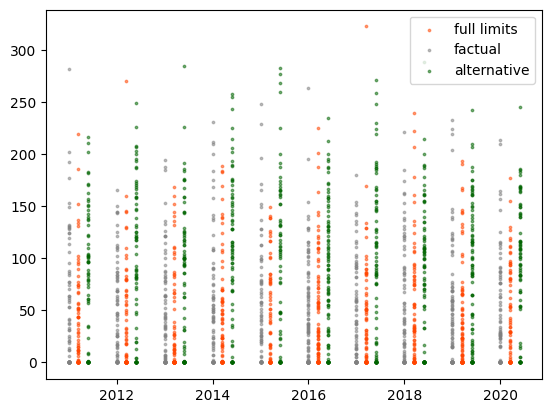

In [77]:

year = tracts_predictor.census_tracts_and_years['year']

print(len(year))
print(full.shape)

plt.scatter(
    x=year + 0.2,
    y=full,
    color="orangered",
    label="full limits",
    s=3,
    alpha=0.5,
)

plt.scatter(
    x = year,
    y = factual,
    color = "grey",
    s = 3,
    alpha = .5,
    label = "factual"
)

plt.scatter(
    x=year + 0.4,
    y=alternative,
    color="darkgreen",
    label="alternative",
    s=3,
    alpha=0.5,
)


plt.legend()
plt.show()

